In [1]:
import numpy as np
import random
import seaborn as sns
import warnings

import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.manifold import TSNE
from umap import UMAP


warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def read_data(filename: str, delimeter=';'):
    with open(filename, mode="r", newline='') as f:
        features = list()
        targets = list()
        for row in f:
            line = list()
            for s in row.split(delimeter):
                s = s.strip()
                if s:
                    line.append(s)
            
            t = int(line[-1])
            if t < 3:
                features.append(list(map(float ,line[1:-1])))
                targets.append(t-1)
            if t == 6:
                features.append(list(map(float ,line[1:-1])))
                targets.append(2)
            if t == 7:
                features.append(list(map(float ,line[1:-1])))
                targets.append(3)
    return features, targets

In [3]:
def make_meshgrid(x, y, h=.02):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        return xx, yy

def plot_contours(model, xx, yy, ax, **params):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_surface(model, xx, yy, ax, **params):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.plot_surface(xx, yy, Z, **params)
    return out

In [4]:
def plot_results(features, targets, model, figsize=(10, 5), in3d=False):
    xx, yy = make_meshgrid(features[:, 0], features[:, 1])

    fig = plt.figure(figsize=(15, 15))
    
    if in3d:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    else:
        ax = fig.gca()
    colormap = 'coolwarm'
    labels = np.unique(targets).tolist()
    palette = np.array(sns.color_palette(colormap, n_colors=len(labels)))
    cmap = sns.color_palette(colormap, as_cmap=True)

    patchs = []
    for i, color in enumerate(palette):
        patchs.append(mpatches.Patch(color=color, label=i))
    if in3d:
        plot_surface(model, xx, yy, ax, cmap=cmap, alpha=0.8)
    else:
        plot_contours(model, xx, yy, ax, cmap=cmap, alpha=0.8)
    plt.scatter(features[:, 0], features[:, 1], c=targets, cmap=cmap, s=40, edgecolors='k')
    # plt.xticks(())
    # plt.yticks(())
    plt.axis('off')
    # plt.legend(handles=patchs, loc='upper right')
    plt.show()

In [5]:
features, targets = read_data('glass.data', delimeter=',')
features = np.array(features)
targets = np.array(targets)

In [6]:
print(classification_report(targets, targets))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        29

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184



In [7]:
np.unique(targets)

array([0, 1, 2, 3])

In [8]:
print(classification_report(targets, targets))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        29

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184



In [9]:
features = UMAP().fit_transform(features)
features = StandardScaler().fit_transform(features)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, stratify=targets, shuffle=True)
x_train.shape, x_test.shape

((128, 2), (56, 2))

# SVM (SVC)

In [11]:
svc_parameters = {
    'kernel':['poly', 'rbf', 'sigmoid'],
    'C': np.linspace(1, 10, 11),
    'degree': np.linspace(3, 6, 4)
}

clf_svc = GridSearchCV(SVC(), svc_parameters)

In [12]:
clf_svc.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
                         'degree': array([3., 4., 5., 6.]),
                         'kernel': ['poly', 'rbf', 'sigmoid']})

In [13]:
clf_svc.best_params_

{'C': 7.3, 'degree': 3.0, 'kernel': 'rbf'}

In [14]:
print(classification_report(y_train, clf_svc.predict(x_train), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.754     0.878     0.811        49
           1      0.750     0.736     0.743        53
           2      0.000     0.000     0.000         6
           3      0.895     0.850     0.872        20

    accuracy                          0.773       128
   macro avg      0.600     0.616     0.606       128
weighted avg      0.739     0.773     0.754       128



In [15]:
print(classification_report(y_test, clf_svc.predict(x_test), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.654     0.810     0.723        21
           1      0.640     0.696     0.667        23
           2      0.000     0.000     0.000         3
           3      1.000     0.556     0.714         9

    accuracy                          0.679        56
   macro avg      0.573     0.515     0.526        56
weighted avg      0.669     0.679     0.660        56



In [16]:
best_svc = SVC(**clf_svc.best_params_)

In [17]:
best_svc.fit(x_train, y_train)

SVC(C=7.3, degree=3.0)

In [18]:
len(best_svc.support_vectors_)

83

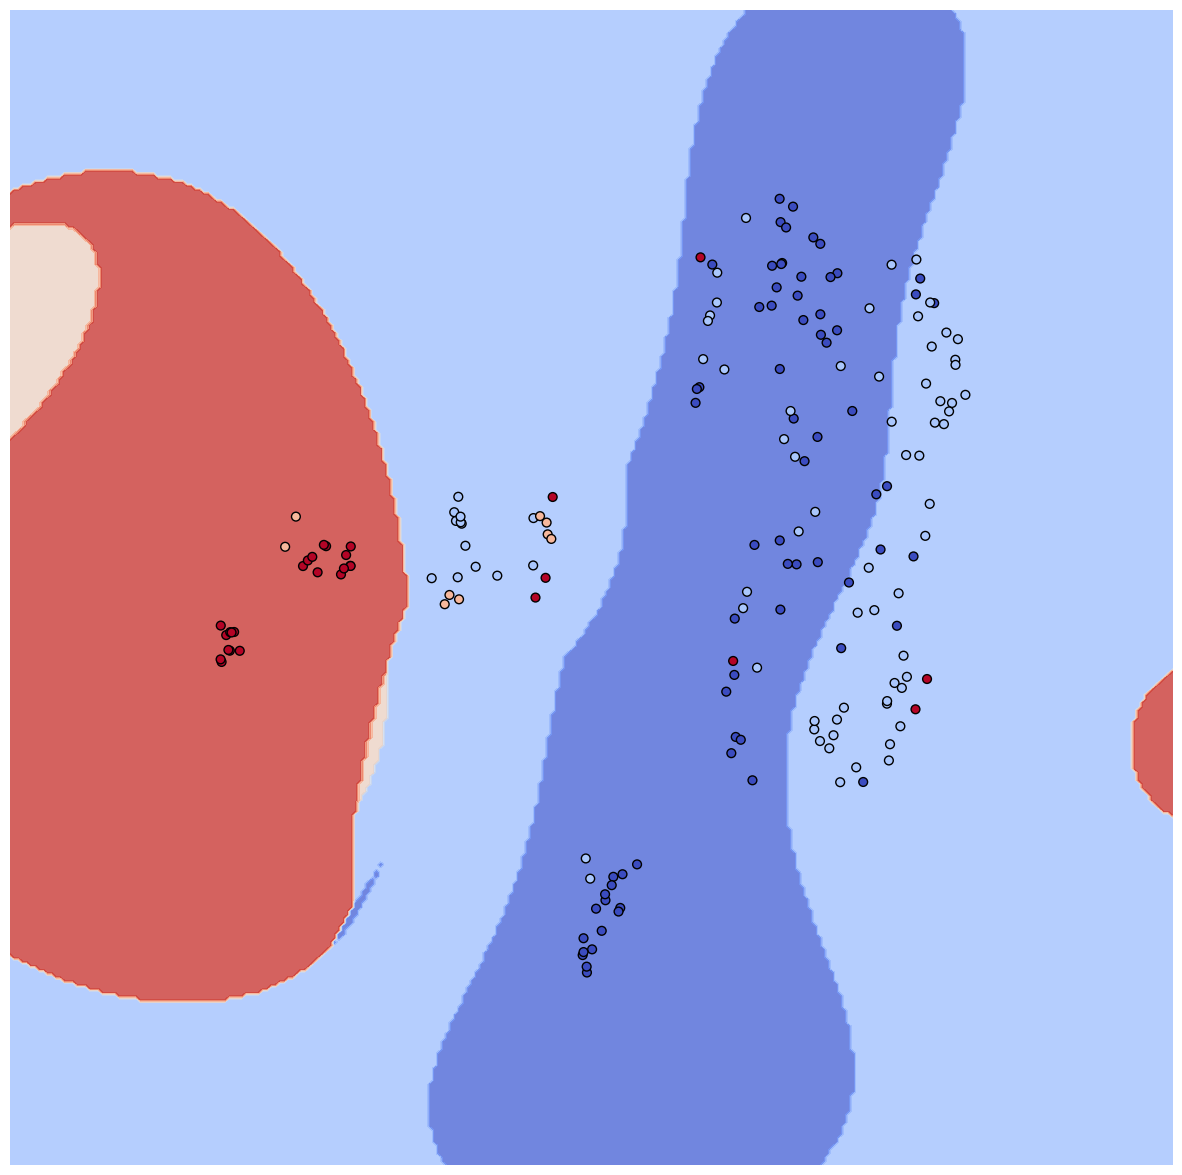

In [19]:
plot_results(features, targets, best_svc, figsize=(15, 10))

<Figure size 1500x1500 with 0 Axes>

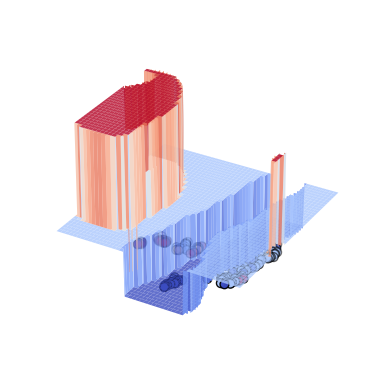

In [20]:
plot_results(features, targets, best_svc, figsize=(13, 13), in3d=True)

# KNN

In [21]:
knn_parameters = {
    'n_neighbors': np.linspace(5, 15, 10, dtype=np.int32),
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['distance', 'uniform'],
    'p': [1, 2]
}

clf_knn = GridSearchCV(KNeighborsClassifier(), knn_parameters)

In [22]:
clf_knn.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 15]),
                         'p': [1, 2], 'weights': ['distance', 'uniform']})

In [23]:
clf_knn.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}

In [24]:
print(classification_report(y_train, clf_knn.predict(x_train), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        49
           1      1.000     1.000     1.000        53
           2      1.000     1.000     1.000         6
           3      1.000     1.000     1.000        20

    accuracy                          1.000       128
   macro avg      1.000     1.000     1.000       128
weighted avg      1.000     1.000     1.000       128



In [25]:
print(classification_report(y_test, clf_knn.predict(x_test), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.708     0.810     0.756        21
           1      0.750     0.783     0.766        23
           2      1.000     1.000     1.000         3
           3      1.000     0.556     0.714         9

    accuracy                          0.768        56
   macro avg      0.865     0.787     0.809        56
weighted avg      0.788     0.768     0.766        56



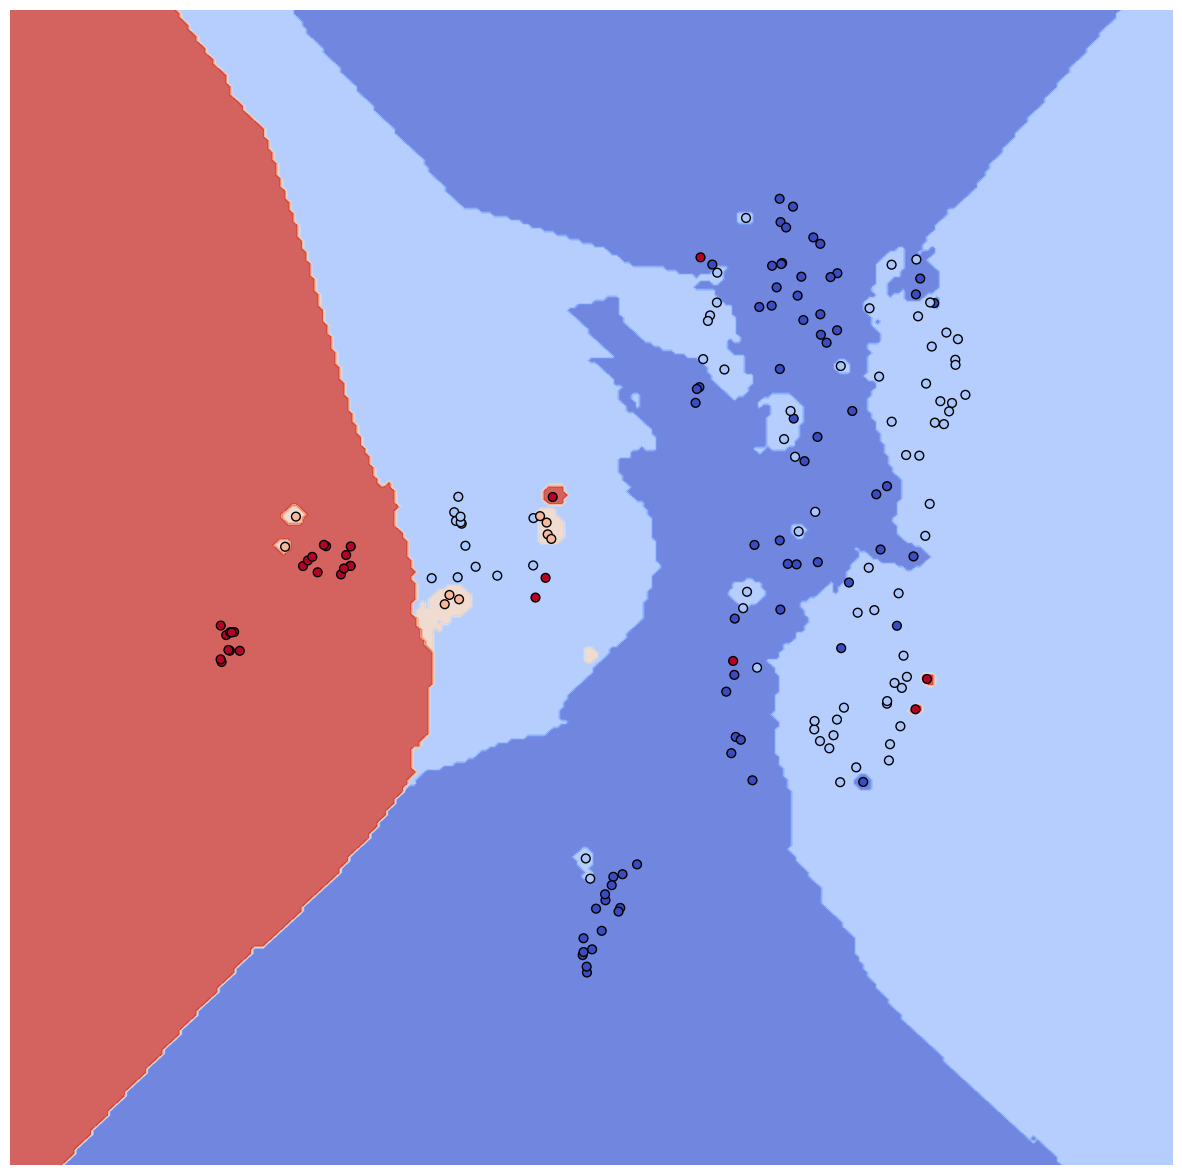

In [26]:
plot_results(features, targets, clf_knn)

<Figure size 1500x1500 with 0 Axes>

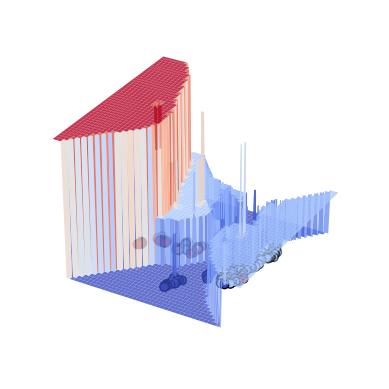

In [27]:
plot_results(features, targets, clf_knn, in3d=True)

# RandomForest

In [28]:
rf_parameters = {
    'n_estimators': np.linspace(5, 50, 10, dtype=np.int32),
    'criterion': ['gini', 'entropy'],
    'max_depth': np.linspace(5, 10, 5, dtype=np.int32),
}

clf_rf = GridSearchCV(RandomForestClassifier(), rf_parameters)

In [29]:
clf_rf.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 5,  6,  7,  8, 10]),
                         'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])})

In [30]:
clf_rf.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 5}

In [31]:
print(classification_report(y_train, clf_rf.predict(x_train), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.980     0.980     0.980        49
           1      0.945     0.981     0.963        53
           2      1.000     0.667     0.800         6
           3      1.000     1.000     1.000        20

    accuracy                          0.969       128
   macro avg      0.981     0.907     0.936       128
weighted avg      0.970     0.969     0.967       128



In [32]:
print(classification_report(y_test, clf_rf.predict(x_test), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.542     0.619     0.578        21
           1      0.560     0.609     0.583        23
           2      0.500     0.333     0.400         3
           3      1.000     0.556     0.714         9

    accuracy                          0.589        56
   macro avg      0.650     0.529     0.569        56
weighted avg      0.621     0.589     0.592        56



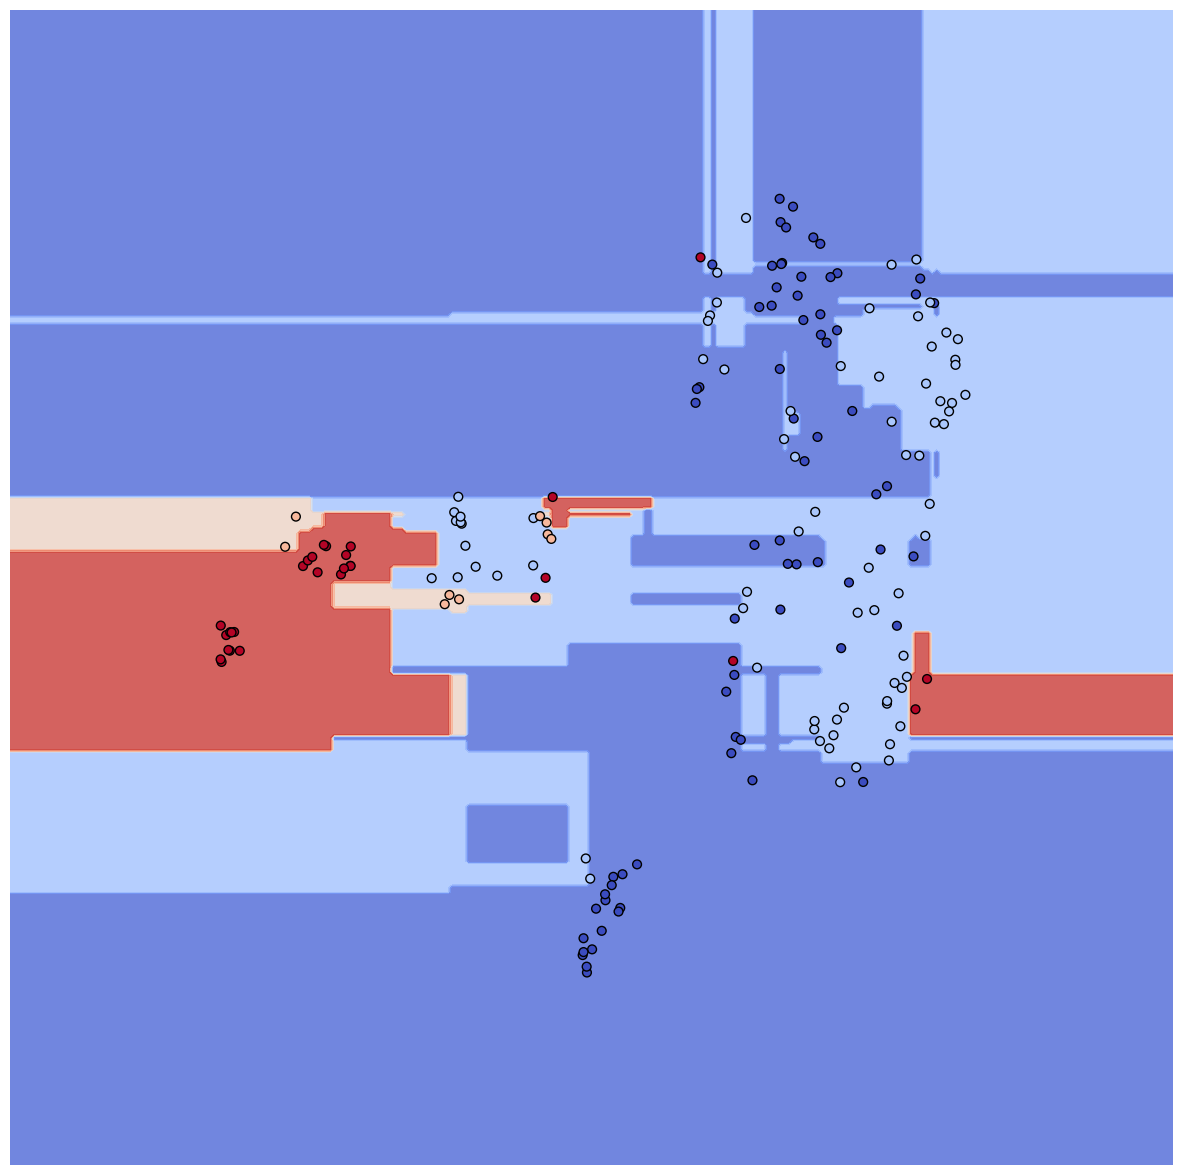

In [33]:
plot_results(features, targets, clf_rf)

<Figure size 1500x1500 with 0 Axes>

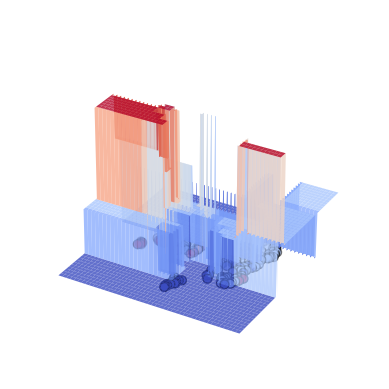

In [34]:
plot_results(features, targets, clf_rf, in3d=True)

# Compare

In [35]:
def plot_bars(features, targets):
    svc_accuracy = round(accuracy_score(targets, best_svc.predict(features)) * 100, 1)
    knn_accuracy = round(accuracy_score(targets, clf_knn.predict(features)) * 100, 1)
    rf_accuracy = round(accuracy_score(targets, clf_rf.predict(features)) * 100, 1)

    svc_precision = round(precision_score(targets, best_svc.predict(features), average='macro') * 100, 1)
    knn_precision = round(precision_score(targets, clf_knn.predict(features), average='macro') * 100, 1)
    rf_precision = round(precision_score(targets, clf_rf.predict(features), average='macro') * 100, 1)

    svc_f1 = round(f1_score(targets, best_svc.predict(features), average='macro') * 100, 1)
    knn_f1 = round(f1_score(targets, clf_knn.predict(features), average='macro') * 100, 1)
    rf_f1 = round(f1_score(targets, clf_rf.predict(features), average='macro') * 100, 1)

    svc_recall = round(recall_score(targets, best_svc.predict(features), average='macro') * 100, 1)
    knn_recall = round(recall_score(targets, clf_knn.predict(features), average='macro') * 100, 1)
    rf_recall = round(recall_score(targets, clf_rf.predict(features), average='macro') * 100, 1)

    labels = ['accuracy', 'precision', 'recall', 'f1']
    svc_metrics = [svc_accuracy, svc_precision, svc_recall, svc_f1]
    knn_metrics = [knn_accuracy, knn_precision, knn_recall, knn_f1]
    rf_metrics = [rf_accuracy, rf_precision, rf_recall, rf_f1]

    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots()

    fig.set_size_inches(12, 5)

    svc_bar = ax.bar(x-width-0.01, svc_metrics, width, label='SVC')
    knn_bar = ax.bar(x, knn_metrics, width, label='KNN')
    rf_bar = ax.bar(x+width+0.01, rf_metrics, width, label='RF')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores, %')
    ax.set_title('Scores for SVC, KNN, RF')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            fancybox=True, shadow=True, ncol=3)

    ax.bar_label(svc_bar)
    ax.bar_label(knn_bar)
    ax.bar_label(rf_bar)

    fig.tight_layout()

    plt.show()

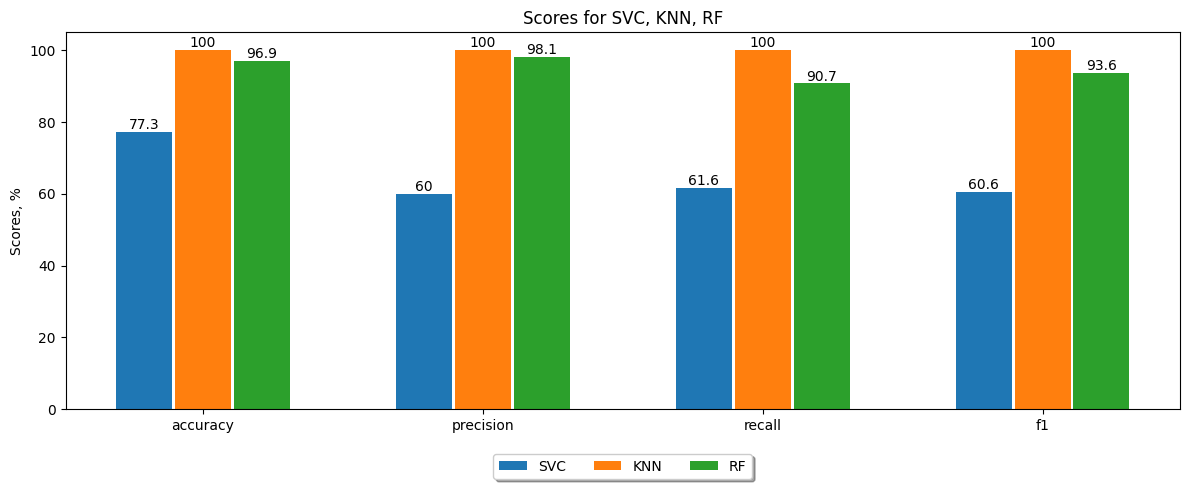

In [36]:
plot_bars(x_train, y_train)

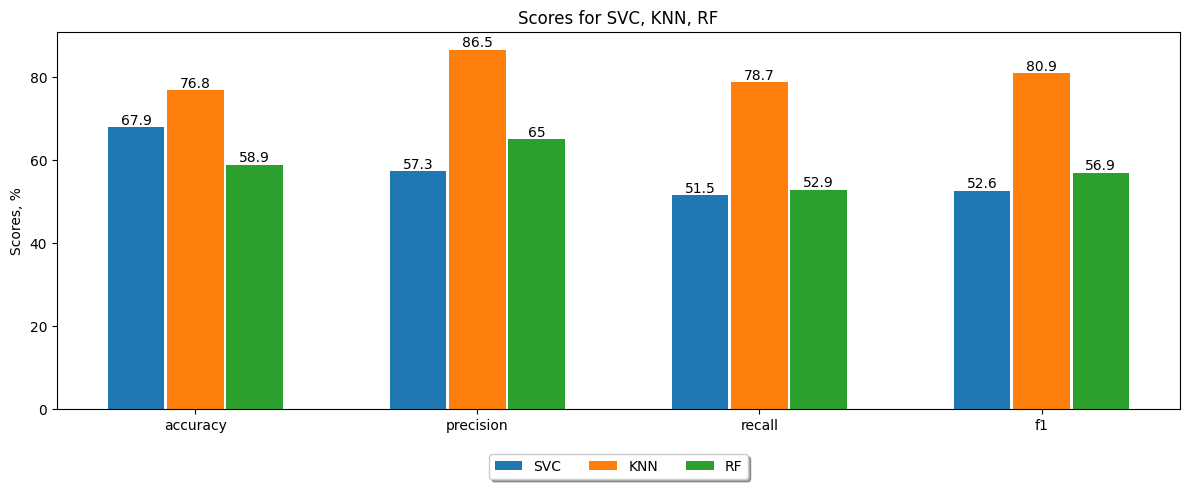

In [37]:
plot_bars(x_test, y_test)